In [ ]:
!pip install ase
!pip install hist
!pip install lmfit
!pip install xraylib

In [ ]:
!wget -O 2024_11_11_V20_I300_T100_CuNiZn.mca "https://raw.githubusercontent.com/simonemanti/incontri-fisica-2024/main/2024_11_11_V20_I300_T100_CuNiZn.mca"

In [2]:
from ase.data import atomic_numbers
import ase.units as units

import glob

import json

import hist

from lmfit import Parameters
from lmfit.models import PolynomialModel, GaussianModel, ExponentialModel, PowerLawModel, RectangleModel

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

import numpy as np

import os

import pandas as pd

import re

from scipy.signal import find_peaks

from uncertainties import unumpy as unp

import xraylib


def load_mca_file(mcafile, rebin=1):

    df = pd.read_csv(mcafile, encoding='cp1252')
    
    counts = []
    save_data = False

    for row in df.to_numpy():
        if row[0] == '<<END>>':
            save_data = False
        if save_data:
            counts.append(float(row[0]))
        if row[0] == '<<DATA>>':
            save_data = True

    counts = np.array(counts, dtype=int)    
    bins = np.arange(8193)
    
    histogram = hist.Hist(
        hist.axis.Variable(bins, name="Ch", label="Channels"),
        storage=hist.storage.Weight(),
    )

    bin_centers = histogram.axes[0].centers

    for center, count in zip(bin_centers, counts):
        histogram.fill(np.full(count, center))

    return histogram[::hist.rebin(rebin)]

# Plot Spettro XRF in canali

Text(0, 0.5, 'Conteggi / 4 Canali')

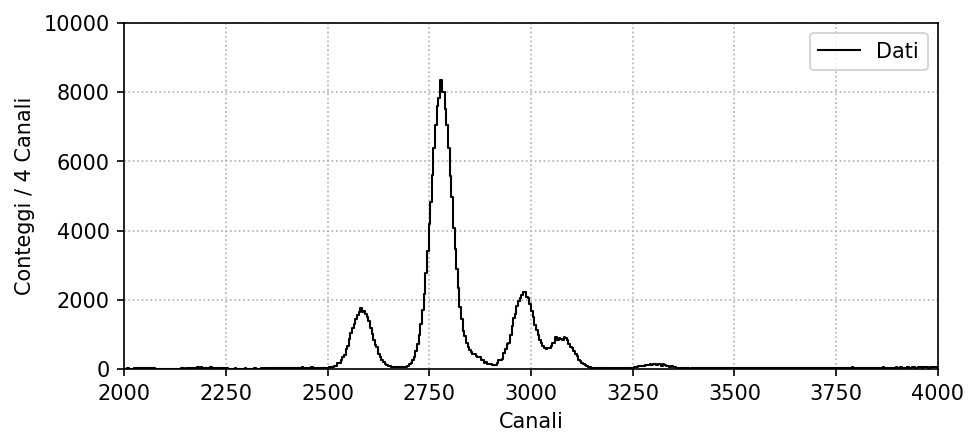

In [3]:
rebin = 4
histogram = load_mca_file('2024_11_11_V20_I300_T100_CuNiZn.mca', rebin=rebin)

fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")
# ax.set_yscale('log')

centers = histogram.axes[0].centers
counts = histogram.values()

ax.step(centers, counts, where='mid', c='k', lw=1, label='Dati')

ax.legend(loc='upper right')
ax.set_xlim(2000,4000)
ax.set_ylim(0,counts.max()*1.2)
ax.set_xlabel('Canali')
ax.set_ylabel(f'Conteggi / {rebin} Canali')

# Fit Spettro XRF in Canali

Definizione del modello per la funzione di fit:

In [4]:
model_1 = PolynomialModel(degree=2)
model_1 += GaussianModel(prefix='NiKa_')
model_1 += GaussianModel(prefix='NiKb_')
model_1 += GaussianModel(prefix='CuKa_')
model_1 += GaussianModel(prefix='CuKb_')
model_1 += GaussianModel(prefix='ZnKa_')
model_1 += GaussianModel(prefix='ZnKb_')

Parametri del modello:

In [6]:
params_1 = Parameters()

params_1.add('c0', value=1)
params_1.add('c1', value=1)
params_1.add('c2', value=1e-2)

params_1.add('NiKa_amplitude', value=1e4, min=0)
params_1.add('NiKa_center', value=2580)
params_1.add('NiKa_sigma', value=30, min=1, max=100)

params_1.add('NiKb_amplitude', value=1e4, min=0)
params_1.add('NiKb_center', value=2880, min=2850, max=2900)
params_1.add('NiKb_sigma', value=30, min=1, max=50)

params_1.add('CuKa_amplitude', value=1e4, min=0)
params_1.add('CuKa_center', value=2780)
params_1.add('CuKa_sigma', value=30, min=1, max=100)

params_1.add('CuKb_amplitude', value=1e4, min=0)
params_1.add('CuKb_center', value=3080, min=3000)
params_1.add('CuKb_sigma', value=30, min=1, max=100)

params_1.add('ZnKa_amplitude', value=1e4, min=0)
params_1.add('ZnKa_center', value=2980, min=2950, max=3000)
params_1.add('ZnKa_sigma', value=30, min=1, max=50)

params_1.add('ZnKb_amplitude', value=1e4, min=0)
params_1.add('ZnKb_center', value=3300, min=3250, max=3350)
params_1.add('ZnKb_sigma', value=30, min=1, max=50)

Fit:

In [7]:
ind = np.where(counts > 0)[0]
x = centers[ind]
y = counts[ind]

result_1 = model_1.fit(y, params_1, x=x, weights=1/np.sqrt(y))
print(result_1.fit_report(show_correl=False))

[[Model]]
    ((((((Model(polynomial) + Model(gaussian, prefix='NiKa_')) + Model(gaussian, prefix='NiKb_')) + Model(gaussian, prefix='CuKa_')) + Model(gaussian, prefix='CuKb_')) + Model(gaussian, prefix='ZnKa_')) + Model(gaussian, prefix='ZnKb_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 381
    # data points      = 1662
    # variables        = 21
    chi-square         = 29521.1527
    reduced chi-square = 17.9897335
    Akaike info crit   = 4823.71585
    Bayesian info crit = 4937.44717
    R-squared          = 0.99996428
[[Variables]]
    c0:             -10.5799173 +/- 0.61627423 (5.82%) (init = 1)
    c1:              0.01693521 +/- 5.8206e-04 (3.44%) (init = 1)
    c2:             -2.0354e-06 +/- 7.1381e-08 (3.51%) (init = 0.01)
    NiKa_amplitude:  107799.955 +/- 2826.58362 (2.62%) (init = 10000)
    NiKa_center:     2584.26053 +/- 0.69144915 (0.03%) (init = 2580)
    NiKa_sigma:      25.6958454 +/- 0.53614659 (2.09%) (init = 30)
    NiKb_amp

Plot risultato del fit:

Text(0, 0.5, 'Conteggi / 4 Canali')

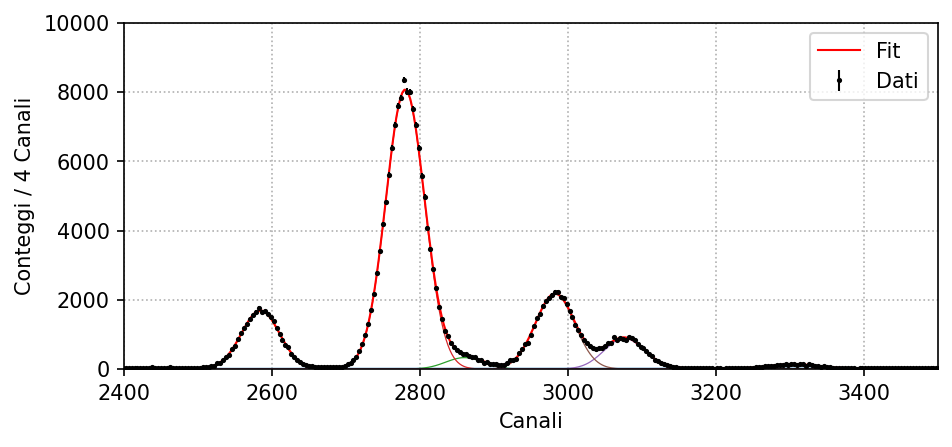

In [8]:
fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")
# ax.set_yscale('log')

centers = histogram.axes[0].centers
counts = histogram.values()

x_i = np.linspace(x[0],x[-1], 3000)
fit_i = model_1.eval(result_1.params, x=x_i)

components = result_1.eval_components(x=x_i)

for key in components.keys():
    ax.plot(x_i, components[key], lw=0.6)

ax.plot(x_i, fit_i, c='r', lw=1, label='Fit')
ax.errorbar(centers, counts, np.sqrt(counts), fmt='o', c='k', lw=1., ms=1.5, capsize=0, label='Dati')

ax.legend(loc='upper right')
ax.set_xlim(2400,3500)
ax.set_ylim(0,counts.max()*1.2)
# ax.set_ylim(10,1.e4)
ax.set_xlabel('Canali')
ax.set_ylabel(f'Conteggi / {rebin} Canali')

# Fit funzione di Calibrazione

Centri dei picchi per le linee Ka:

In [9]:
params_1 = result_1.params

canali = [param.value for param in params_1.values() if 'Ka_center' in param.name]
canali

[2584.260534714548, 2779.872328993246, 2982.513913059382]

Energie di riferimento:

In [10]:
ref_energies = []

ref_energies.append(xraylib.LineEnergy(xraylib.SymbolToAtomicNumber('Ni'), xraylib.KA_LINE) * 1e3)
ref_energies.append(xraylib.LineEnergy(xraylib.SymbolToAtomicNumber('Cu'), xraylib.KA_LINE) * 1e3)
ref_energies.append(xraylib.LineEnergy(xraylib.SymbolToAtomicNumber('Zn'), xraylib.KA_LINE) * 1e3)

ref_energies

[7472.2769470121975, 8041.05061567418, 8631.0590577321]

Plot centri vs energie:

Text(0, 0.5, 'Energie [eV]')

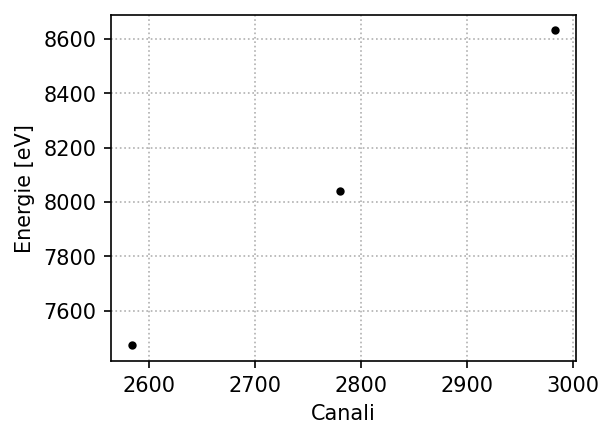

In [11]:
fig, ax = plt.subplots(figsize=(4,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")

ax.errorbar(canali, ref_energies, fmt='o', c='k', lw=1, ms=3)

ax.set_xlabel('Canali')
ax.set_ylabel('Energie [eV]')

Definizione del modello di fit per la funzione di calibrazione:

In [12]:
model_2 = PolynomialModel(degree=1)

Parametri della funzione di calibrazione

In [13]:
params_2 = Parameters()

params_2.add('c0', value=1)
params_2.add('c1', value=1)

Fit funzione di calibrazione:

In [14]:
x = canali
y = ref_energies

result_2 = model_2.fit(y, params_2, x=x)
print(result_2.fit_report(show_correl=False))

[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 3
    # variables        = 2
    chi-square         = 0.10151220
    reduced chi-square = 0.10151220
    Akaike info crit   = -6.15856561
    Bayesian info crit = -7.96134104
    R-squared          = 0.99999985
[[Variables]]
    c0: -47.2059232 +/- 3.15299473 (6.68%) (init = 1)
    c1:  2.90967200 +/- 0.00113134 (0.04%) (init = 1)


Plot funzione di Calibrazione:

Text(0, 0.5, 'Energie [eV]')

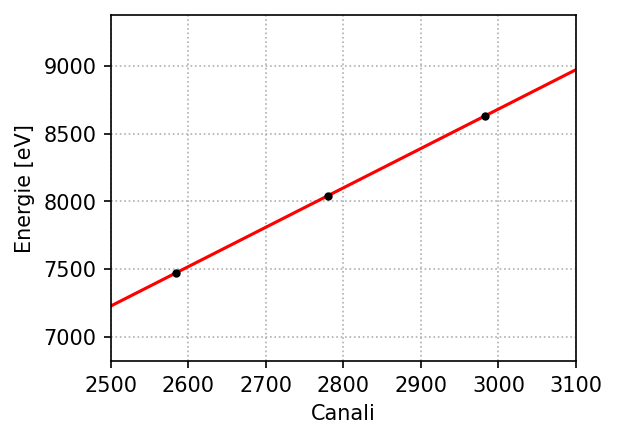

In [15]:
fig, ax = plt.subplots(figsize=(4,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")

ax.errorbar(canali, ref_energies, fmt='o', c='k', lw=1, ms=3)

x_i = np.linspace(2400,3200, 1000)
fit_i = model_2.eval(result_2.params, x=x_i)

ax.plot(x_i, fit_i, c='r')

ax.set_xlim(2500,3100)

ax.set_xlabel('Canali')
ax.set_ylabel('Energie [eV]')

# Calibrazione Spettro in energie

$$

Energie = offset + gain \cdot Canali

$$

In [16]:
offset = result_2.params['c0'].value
gain = result_2.params['c1'].value

energies = gain * centers + offset 

Plot Spettro XRF calibrato:

Text(0, 0.5, 'Conteggi / 4 Canali')

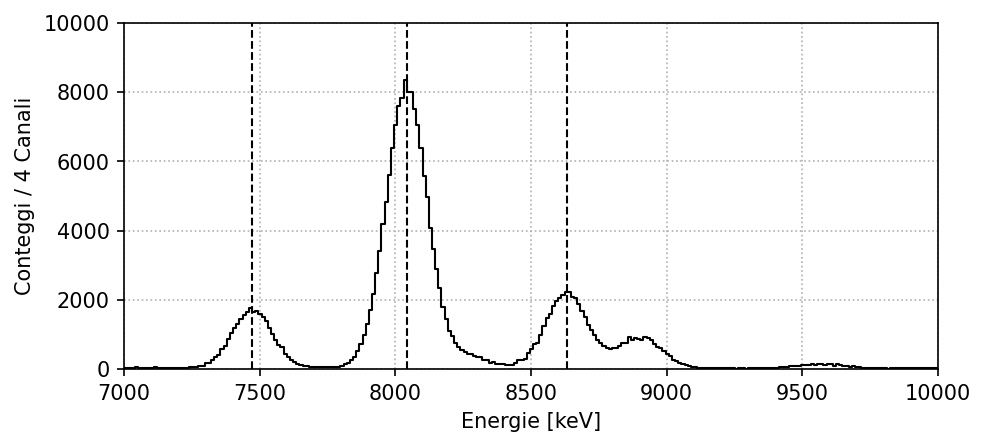

In [17]:
fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")
# ax.set_yscale('log')

ax.axvline(ref_energies[0], c='k', lw=1, ls='--')
ax.axvline(ref_energies[1], c='k', lw=1, ls='--')
ax.axvline(ref_energies[2], c='k', lw=1, ls='--')

ax.step(energies, counts, where='mid', c='k', lw=1)

# ax.set_xlim(0,8192)
ax.set_xlim(7e3,10e3)
ax.set_ylim(0,counts.max()*1.2)
ax.set_xlabel('Energie [keV]')
ax.set_ylabel(f'Conteggi / {rebin} Canali')


# Fit spettro calibrato

In [18]:
model_3 = PolynomialModel(degree=2)
model_3 += GaussianModel(prefix='NiKa_')
model_3 += GaussianModel(prefix='NiKb_')
model_3 += GaussianModel(prefix='CuKa_')
model_3 += GaussianModel(prefix='CuKb_')
model_3 += GaussianModel(prefix='ZnKa_')
model_3 += GaussianModel(prefix='ZnKb_')

In [19]:
ref_energies = []

ref_energies.append(xraylib.LineEnergy(xraylib.SymbolToAtomicNumber('Ni'), xraylib.KA_LINE) * 1e3)
ref_energies.append(xraylib.LineEnergy(xraylib.SymbolToAtomicNumber('Ni'), xraylib.KB_LINE) * 1e3)
ref_energies.append(xraylib.LineEnergy(xraylib.SymbolToAtomicNumber('Cu'), xraylib.KA_LINE) * 1e3)
ref_energies.append(xraylib.LineEnergy(xraylib.SymbolToAtomicNumber('Cu'), xraylib.KB_LINE) * 1e3)
ref_energies.append(xraylib.LineEnergy(xraylib.SymbolToAtomicNumber('Zn'), xraylib.KA_LINE) * 1e3)
ref_energies.append(xraylib.LineEnergy(xraylib.SymbolToAtomicNumber('Zn'), xraylib.KB_LINE) * 1e3)

ref_energies = np.array(ref_energies)
ref_energies

array([7472.27694701, 8264.7       , 8041.05061567, 8905.3       ,
       8631.05905773, 9572.        ])

In [20]:
delta = 100

params_3 = Parameters()

params_3.add('ENC', value=120, min=50, max=200)
params_3.add('FF', value=0.1, min=0, max=0.2)
params_3.add('SiW', value=3.81, vary=False)

params_3.add('c0', value=1)
params_3.add('c1', value=1)
params_3.add('c2', value=1e-2)

params_3.add('NiKa_amplitude', value=1e4, min=0)
params_3.add('NiKa_center', value=ref_energies[0], min=ref_energies[0]-delta, max=ref_energies[0]+delta)
params_3.add('NiKa_sigma', value=30, expr=f'sqrt((ENC/2.35)**2 + FF * NiKa_center * SiW)')

params_3.add('NiKb_amplitude', value=1e4, min=0)
params_3.add('NiKb_center', value=ref_energies[1], min=ref_energies[1]-delta, max=ref_energies[1]+delta)
params_3.add('NiKb_sigma', value=30, expr=f'sqrt((ENC/2.35)**2 + FF * NiKb_center * SiW)')

params_3.add('CuKa_amplitude', value=1e4, min=0)
params_3.add('CuKa_center', value=ref_energies[2], min=ref_energies[2]-delta, max=ref_energies[2]+delta)
params_3.add('CuKa_sigma', value=30, expr=f'sqrt((ENC/2.35)**2 + FF * CuKa_center * SiW)')

params_3.add('CuKb_amplitude', value=1e4, min=0)
params_3.add('CuKb_center', value=ref_energies[3], min=ref_energies[3]-delta, max=ref_energies[3]+delta)
params_3.add('CuKb_sigma', value=30, expr=f'sqrt((ENC/2.35)**2 + FF * CuKb_center * SiW)')

params_3.add('ZnKa_amplitude', value=1e4, min=0)
params_3.add('ZnKa_center', value=ref_energies[4], min=ref_energies[4]-delta, max=ref_energies[4]+delta)
params_3.add('ZnKa_sigma', value=30, expr=f'sqrt((ENC/2.35)**2 + FF * ZnKa_center * SiW)')

params_3.add('ZnKb_amplitude', value=1e4, min=0)
params_3.add('ZnKb_center', value=ref_energies[5], min=ref_energies[5]-delta, max=ref_energies[5]+delta)
params_3.add('ZnKb_sigma', value=30, expr=f'sqrt((ENC/2.35)**2 + FF * ZnKb_center * SiW)')

In [21]:
ind = np.where(counts > 0)[0]
x = energies[ind]
y = counts[ind]

result_3 = model_3.fit(y, params_3, x=x, weights=1/np.sqrt(y))
print(result_3.fit_report(show_correl=False))

[[Model]]
    ((((((Model(polynomial) + Model(gaussian, prefix='NiKa_')) + Model(gaussian, prefix='NiKb_')) + Model(gaussian, prefix='CuKa_')) + Model(gaussian, prefix='CuKb_')) + Model(gaussian, prefix='ZnKa_')) + Model(gaussian, prefix='ZnKb_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 127
    # data points      = 1662
    # variables        = 17
    chi-square         = 29529.2725
    reduced chi-square = 17.9509255
    Akaike info crit   = 4816.17292
    Bayesian info crit = 4908.24113
    R-squared          = 0.99996427
[[Variables]]
    ENC:             123.753831 +/- 43.8254938 (35.41%) (init = 120)
    FF:              0.09723803 +/- 0.06351276 (65.32%) (init = 0.1)
    SiW:             3.81 (fixed)
    c0:             -10.3284750 +/- 0.60622685 (5.87%) (init = 1)
    c1:              0.00580917 +/- 1.9803e-04 (3.41%) (init = 1)
    c2:             -2.4091e-07 +/- 8.3786e-09 (3.48%) (init = 0.01)
    NiKa_amplitude:  313566.602 +/- 8211.15735

Text(0, 0.5, 'Conteggi / 4 Canali')

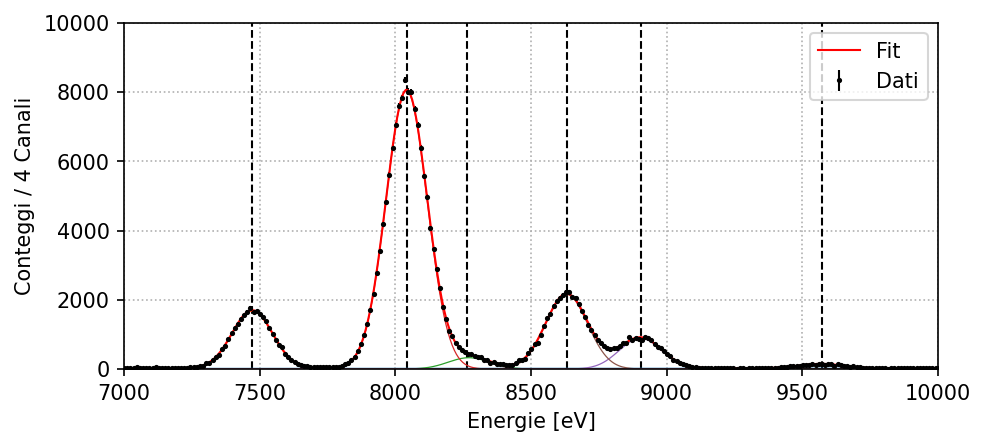

In [23]:
fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")

centers = histogram.axes[0].centers
counts = histogram.values()

x_i = np.linspace(x[0],x[-1], 3000)
fit_i = model_3.eval(result_3.params, x=x_i)

components = result_3.eval_components(x=x_i)

ax.axvline(ref_energies[0], c='k', lw=1, ls='--')
ax.axvline(ref_energies[1], c='k', lw=1, ls='--')
ax.axvline(ref_energies[2], c='k', lw=1, ls='--')
ax.axvline(ref_energies[3], c='k', lw=1, ls='--')
ax.axvline(ref_energies[4], c='k', lw=1, ls='--')
ax.axvline(ref_energies[5], c='k', lw=1, ls='--')

for key in components.keys():
    ax.plot(x_i, components[key], lw=0.6)

ax.errorbar(energies, counts, np.sqrt(counts), fmt='o', c='k', lw=1., ms=1.5, capsize=0, label='Dati')
ax.plot(x_i, fit_i, c='r', lw=1, label='Fit')

ax.legend(loc='upper right')
ax.set_xlim(7000,10000)
ax.set_ylim(0,counts.max()*1.2)
# ax.set_yscale('log')
# ax.set_ylim(10,1.e4)
ax.set_xlabel('Energie [eV]')
ax.set_ylabel(f'Conteggi / {rebin} Canali')

# Calcolo Residui

In [24]:
params_3 = result_3.params

energie_fit = np.array([param.value for param in params_3.values() if 'center' in param.name])
err_energie_fit = np.array([param.stderr for param in params_3.values() if 'center' in param.name])
labels = [param.name.split('_')[0] for param in params_3.values() if 'center' in param.name]

energie_fit

array([7472.14065223, 8271.13860584, 8041.16410166, 8903.27959809,
       8631.2248588 , 9569.52647393])

Text(0, 0.5, 'Residui [eV]')

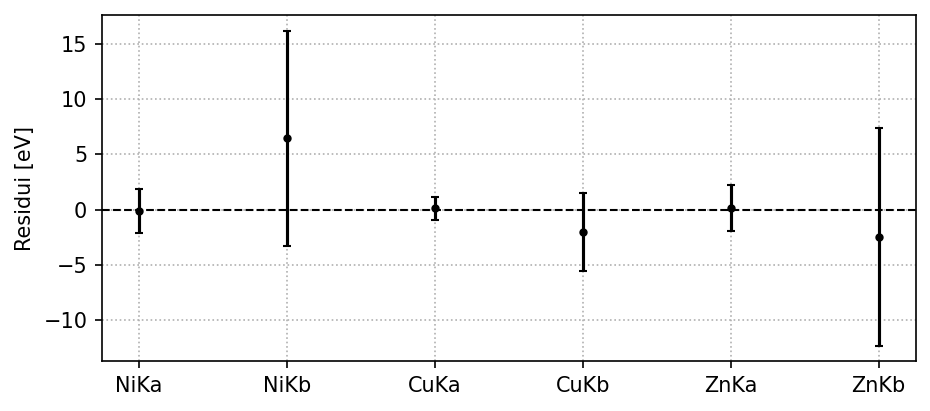

In [25]:
fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")

residui = energie_fit - ref_energies

ax.axhline(0, c='k', lw=1, ls='--')

ax.errorbar(range(6), residui, err_energie_fit, fmt='o', c='k', ms=3, capsize=2)

ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_ylabel('Residui [eV]')


In [26]:
REBIN = 4
width = 1

amplitudes_values = [param.value / REBIN / width for param in params_3.values() if 'Ka_amplitude' in param.name]
amplitudes_errors = [param.stderr / REBIN / width for param in params_3.values() if 'Ka_amplitude' in param.name]

amplitudes = unp.uarray(amplitudes_values, amplitudes_errors)
wts = amplitudes / amplitudes.sum() * 100

Text(0, 0.5, 'Concentrazione  %')

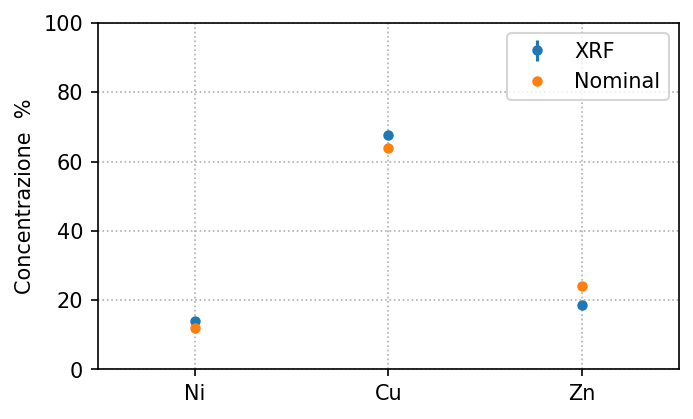

In [37]:
fig, ax = plt.subplots(figsize=(5,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")
ax.set_axisbelow(True)

ax.errorbar(range(3), unp.nominal_values(wts), unp.std_devs(wts), fmt='o', ms=4, label='XRF')
ax.errorbar(range(3), [12,64,24], fmt='o', ms=4, label='Nominal')

ax.legend()
ax.set_xlim(-0.5,2.5)
ax.set_ylim(0,100)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Ni','Cu','Zn'])
ax.set_ylabel('Concentrazione  %')

# Monete

In [ ]:
!wget -O 2024_11_11_V20_I300_T100_1euro.mca "https://raw.githubusercontent.com/simonemanti/incontri-fisica-2024/main/2024_11_11_V20_I300_T100_1euro.mca"
!wget -O 2024_11_11_V20_I300_T100_2euro.mca "https://raw.githubusercontent.com/simonemanti/incontri-fisica-2024/main/2024_11_11_V20_I300_T100_2euro.mca"

Text(0, 0.5, 'Conteggi / 12 eV')

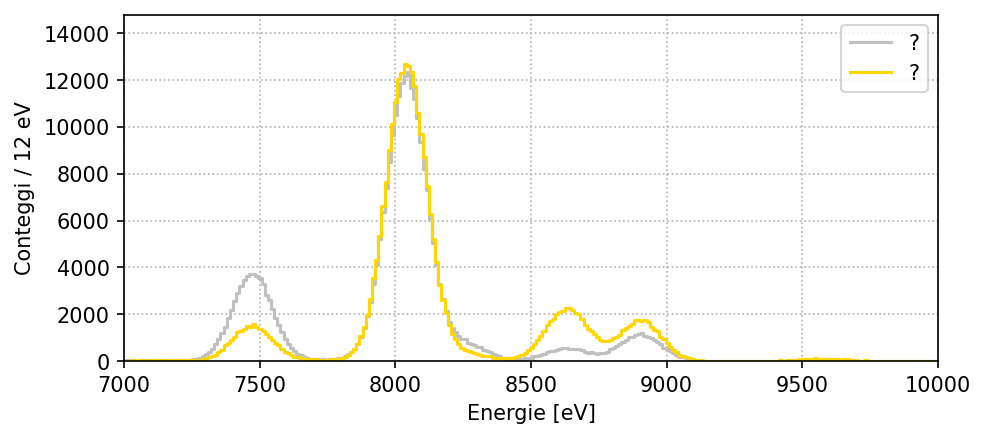

In [38]:
rebin = 4
histogram_1 = load_mca_file('2024_11_11_V20_I300_T100_1euro.mca', rebin=rebin)
histogram_2 = load_mca_file('2024_11_11_V20_I300_T100_2euro.mca', rebin=rebin)

fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")
# ax.set_yscale('log')

centers_1 = histogram_1.axes[0].centers
counts_1 = histogram_1.values()
energies_1 = gain * centers_1 + offset

centers_2 = histogram_2.axes[0].centers
counts_2 = histogram_2.values()
energies_2 = gain * centers_2 + offset

ax.step(energies_1, counts_1, where='mid', c='#C0C0C0', lw=1.5, label='?')
ax.step(energies_2, counts_2, where='mid', c='#FFD700', lw=1.5, label='?')

ax.legend(loc='upper right')
ax.set_xlim(7000,10000)
ax.set_ylim(0,counts_1.max()*1.2)
ax.set_xlabel('Energie [eV]')
ax.set_ylabel(f'Conteggi / {np.diff(energies_1)[0]:.0f} eV')

## Moneta 1

In [39]:
ind = np.where(counts_1 > 0)[0]
x = energies_1[ind]
y = counts_1[ind]

result_4 = model_3.fit(y, params_3, x=x, weights=1/np.sqrt(y))
print(result_4.fit_report(show_correl=False))

[[Model]]
    ((((((Model(polynomial) + Model(gaussian, prefix='NiKa_')) + Model(gaussian, prefix='NiKb_')) + Model(gaussian, prefix='CuKa_')) + Model(gaussian, prefix='CuKb_')) + Model(gaussian, prefix='ZnKa_')) + Model(gaussian, prefix='ZnKb_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 185
    # data points      = 1754
    # variables        = 17
    chi-square         = 48245.2373
    reduced chi-square = 27.7750359
    Akaike info crit   = 5847.45448
    Bayesian info crit = 5940.43860
    R-squared          = 0.99997336
[[Variables]]
    ENC:             158.823635 +/- 37.2422006 (23.45%) (init = 123.7538)
    FF:              0.03507766 +/- 0.07061072 (201.30%) (init = 0.09723803)
    SiW:             3.81 (fixed)
    c0:             -8.61120016 +/- 0.73238165 (8.50%) (init = -10.32848)
    c1:              0.00523298 +/- 2.2789e-04 (4.35%) (init = 0.005809174)
    c2:             -2.1574e-07 +/- 9.3356e-09 (4.33%) (init = -2.40905e-07)
    NiK

Text(0, 0.5, 'Concentrazione  %')

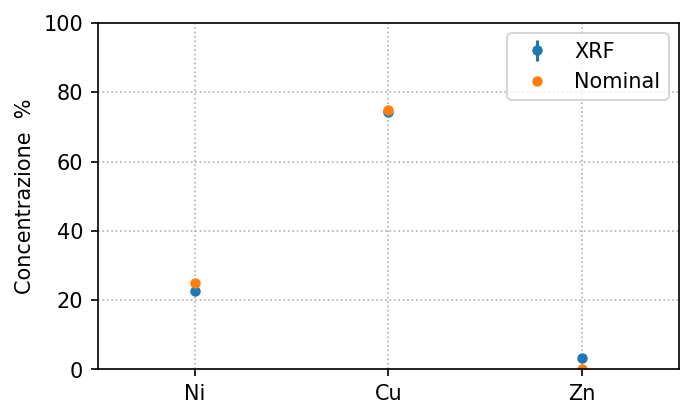

In [45]:
REBIN = 4
width = 1

params_4 = result_4.params

amplitudes_values_1 = [param.value / REBIN / width for param in params_4.values() if 'Ka_amplitude' in param.name]
amplitudes_errors_1 = [param.stderr / REBIN / width for param in params_4.values() if 'Ka_amplitude' in param.name]

amplitudes_1 = unp.uarray(amplitudes_values_1, amplitudes_errors_1)
wts_1 = amplitudes_1 / amplitudes_1.sum() * 100

fig, ax = plt.subplots(figsize=(5,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")
ax.set_axisbelow(True)

ax.errorbar(range(3), unp.nominal_values(wts_1), unp.std_devs(wts_1), fmt='o', ms=4, label='XRF')
ax.errorbar(range(3), [25,75,0], fmt='o', ms=4, label='Nominal')
# ax.errorbar(range(3), [5,75,20], fmt='o', ms=4, label='Nominal')

ax.legend()
ax.set_xlim(-0.5,2.5)
ax.set_ylim(0,100)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Ni','Cu','Zn'])
ax.set_ylabel('Concentrazione  %')

## Moneta 2

In [42]:
ind = np.where(counts_2 > 0)[0]
x = energies_2[ind]
y = counts_2[ind]

result_5 = model_3.fit(y, params_3, x=x, weights=1/np.sqrt(y))
print(result_5.fit_report(show_correl=False))

[[Model]]
    ((((((Model(polynomial) + Model(gaussian, prefix='NiKa_')) + Model(gaussian, prefix='NiKb_')) + Model(gaussian, prefix='CuKa_')) + Model(gaussian, prefix='CuKb_')) + Model(gaussian, prefix='ZnKa_')) + Model(gaussian, prefix='ZnKb_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 202
    # data points      = 1699
    # variables        = 17
    chi-square         = 32902.0152
    reduced chi-square = 19.5612457
    Akaike info crit   = 5068.97642
    Bayesian info crit = 5161.41894
    R-squared          = 0.99998267
[[Variables]]
    ENC:             175.566389 +/- 29.0052759 (16.52%) (init = 123.7538)
    FF:              0.00525359 +/- 0.05975399 (1137.39%) (init = 0.09723803)
    SiW:             3.81 (fixed)
    c0:             -5.84617321 +/- 0.56816024 (9.72%) (init = -10.32848)
    c1:              0.00380425 +/- 1.7012e-04 (4.47%) (init = 0.005809174)
    c2:             -1.5564e-07 +/- 7.0698e-09 (4.54%) (init = -2.40905e-07)
    Ni

Text(0, 0.5, 'Concentrazione  %')

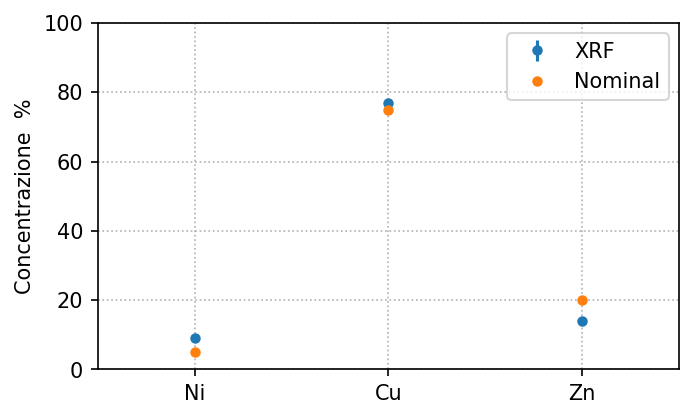

In [44]:
params_5 = result_5.params

amplitudes_values_2 = [param.value / REBIN / width for param in params_5.values() if 'Ka_amplitude' in param.name]
amplitudes_errors_2 = [param.stderr / REBIN / width for param in params_5.values() if 'Ka_amplitude' in param.name]

amplitudes_2 = unp.uarray(amplitudes_values_2, amplitudes_errors_2)
wts_2 = amplitudes_2 / amplitudes_2.sum() * 100

fig, ax = plt.subplots(figsize=(5,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")
ax.set_axisbelow(True)

ax.errorbar(range(3), unp.nominal_values(wts_2), unp.std_devs(wts_2), fmt='o', ms=4, label='XRF')
# ax.errorbar(range(3), [25,75,0], fmt='o', ms=4, label='Nominal')
ax.errorbar(range(3), [5,75,20], fmt='o', ms=4, label='Nominal')

ax.legend()
ax.set_xlim(-0.5,2.5)
ax.set_ylim(0,100)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Ni','Cu','Zn'])
ax.set_ylabel('Concentrazione  %')